# Waste Data Exploratory Analysis


In [1]:
library(tidyverse)
library(rgeos)
library(raster)
library(rgdal)
library(viridis)
library(gtable)
library(grid)
library(readxl)
library(janitor)
library(sf)
library(lubridate)

options( warn = -1 )

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.2.0     v purrr   0.3.2
v tibble  2.1.3     v dplyr   0.8.1
v tidyr   0.8.3     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"package 'rgeos' was built under R version 3.6.1"Loading required package: sp
rgeos version: 0.5-1, (SVN revision 614)
 GEOS runtime version: 3.6.1-CAPI-1.10.1 
 Linking to sp version: 1.3-1 
 Polygon checking: TRUE 

Warning message:
"package 'raster' was built under R version 3.6.1"
Attaching package: 'raster'

The following object is masked from 'package:dplyr':

    select

The following object is masked from 'package:tidyr':

    extract

Warning message:
"package 'rgdal' was built under R version 3.6.1"rgdal: version: 1.4-4, (SVN revision 833)
 Geospatial Data Abstraction Library extensi

SOURCE OF DATA: NYC OPEN DATA, NYC PLANNING POPULATION FACT FINDER

DATASET: DSNY Monthly Tonnage Data https://data.cityofnewyork.us/City-Government/DSNY-Monthly-Tonnage-Data/ebb7-mvp5
         GIS data: Boundaries of Community Districts https://data.cityofnewyork.us/City-Government/Community-Districts/yfnk-k7r4
         NYC POPULATION https://popfactfinder.planning.nyc.gov/#12.25/40.724/-73.9868
         
LAST UPDATE: 5/27/2019
EXTRACTION DATE: 11/17/2018 9:10

WASTE TYPE: 

REFUSETONSCOLLECTED --- Tons of trash or refuse collected from NYC residences and institutions serviced by the NYC Department of Sanitation. Within DSNY, the code for refuse is 01.

PAPERTONSCOLLECTED --- Tons of source-separated recyclable paper collected from NYC residences and institutions serviced by the NYC Department of Sanitation. "Source separated" means that materials are separated by residents before they are set out for collection. Within DSNY, the code for paper is 31.

MGPTONSCOLLECTED --- Tons of source-separated recyclable metal, glass, plastic, and beverage cartons collected from NYC residences and institutions serviced by the NYC Department of Sanitation. "Source separated" means that materials are separated by residents before they are set out for collection. Within DSNY, the code for metal, glass, plastic (MGP) is 33.

RESORGANICSTONS --- Tons of source-separated residential organics collected from NYC residences serviced by the NYC Department of Sanitation. Only certain areas within NYC receive this service. Residential organics includes food scraps, food-soiled paper and yard waste. "Source separated" means that materials are separated by residents before they are set out for collection. Within DSNY, the code for residential organics is 45.

TIME SERIES: 1997 to 2016, aggregated monthly data

GEO: NYC boroughs and community districts aggregates

UNITS: Tones, Pounds, Percentages

WASTE OPERATION: Waste generated, Recovery, Recovery - incineration with energy recovery (packaging), Recovery - energy recovery (R1), Recovery - other, Recycling, Recycling - material, Recycling - other

FLOW: Waste generated in NYC

## DATA ANALYSIS QUESTIONS

1. Rank all community districts by total amount of waste and compare it to the ranking of districts by the waste per capita.

2. How has the volume per capita of refuse evolved for each community district?

3. Do amounts of waste across the five boroughs differ (total and per person)? Is it possible to detect a distinct trend?



# Data cleaning

In [2]:
# 1. read in waste data
month_ton <- read_csv("month_ton.csv")

Parsed with column specification:
cols(
  MONTH = col_character(),
  BOROUGH = col_character(),
  COMMUNITYDISTRICT = col_character(),
  REFUSETONSCOLLECTED = col_double(),
  PAPERTONSCOLLECTED = col_double(),
  MGPTONSCOLLECTED = col_double(),
  RESORGANICSTONS = col_logical(),
  SCHOOLORGANICTONS = col_logical(),
  LEAVESORGANICTONS = col_double(),
  XMASTREETONS = col_double(),
  BOROUGH_ID = col_double()
)


In [3]:
new <- cols(
  MONTH = col_character(),
  BOROUGH = col_character(),
  COMMUNITYDISTRICT = col_character(),
  REFUSETONSCOLLECTED = col_double(),
  PAPERTONSCOLLECTED = col_double(),
  MGPTONSCOLLECTED = col_double(),
  RESORGANICSTONS = col_character(),
  SCHOOLORGANICTONS = col_character(),
  LEAVESORGANICTONS = col_double(),
  XMASTREETONS = col_double(),
  BOROUGH_ID = col_integer()
)

In [4]:
# clean column names
ton_df <- str_glue("month_ton.csv") %>% 
  read_csv(col_types = new) %>% 
  clean_names()

In [5]:
glimpse(ton_df)

Observations: 19,750
Variables: 11
$ month               <chr> "1990 / 08", "1990 / 10", "1990 / 10", "1990 / ...
$ borough             <chr> "Manhattan", "Manhattan", "Staten Island", "Man...
$ communitydistrict   <chr> "03", "03", "02", "07", "02", "10", "02", "06",...
$ refusetonscollected <dbl> 3258.3, 3829.9, 4379.5, 3463.6, 3014.2, 3062.3,...
$ papertonscollected  <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,...
$ mgptonscollected    <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,...
$ resorganicstons     <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,...
$ schoolorganictons   <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,...
$ leavesorganictons   <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,...
$ xmastreetons        <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,...
$ borough_id          <int> 1, 1, 5, 1, 1, 1, 5, 1, 5, 4, 1, 1, 1, 5, 4, 4,...


In [6]:
# 2. read in community district shapefile
cd <- st_read("nycd.shp")

Reading layer `nycd' from data source `C:\Users\aslop\R FOR DATA SCIENCE\Waste NYC\nycd.shp' using driver `ESRI Shapefile'
Simple feature collection with 71 features and 6 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: -74.25559 ymin: 40.49612 xmax: -73.70001 ymax: 40.91553
epsg (SRID):    4326
proj4string:    +proj=longlat +datum=WGS84 +no_defs


In [7]:
head(cd)

Registered S3 method overwritten by 'geojsonio':
  method         from 
  print.location dplyr


borocd,shape_leng,shape_area,cartodb_id,created_at,updated_at,geometry
<int>,<dbl>,<dbl>,<int>,<date>,<date>,<MULTIPOLYGON [°]>
480,45440.92,32723604,4,2015-04-07,2015-04-07,MULTIPOLYGON (((-73.86275 4...
405,70097.83,210385391,27,2015-04-07,2015-04-07,MULTIPOLYGON (((-73.8877 40...
307,88672.45,104136255,15,2015-04-07,2015-04-07,MULTIPOLYGON (((-73.98017 4...
501,157923.97,376963080,7,2015-04-07,2015-04-07,MULTIPOLYGON (((-74.15946 4...
318,190218.26,235680520,8,2015-04-07,2015-04-07,MULTIPOLYGON (((-73.91513 4...
104,67935.23,49291812,18,2015-04-07,2015-04-07,MULTIPOLYGON (((-73.99394 4...


# Data prep

In [8]:
head(ton_df)

month,borough,communitydistrict,refusetonscollected,papertonscollected,mgptonscollected,resorganicstons,schoolorganictons,leavesorganictons,xmastreetons,borough_id
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>
1990 / 08,Manhattan,03,3258.3,NA,NA,NA,NA,NA,NA,1
1990 / 10,Manhattan,03,3829.9,NA,NA,NA,NA,NA,NA,1
1990 / 10,Staten Island,02,4379.5,NA,NA,NA,NA,NA,NA,5
1990 / 10,Manhattan,07,3463.6,NA,NA,NA,NA,NA,NA,1
1990 / 11,Manhattan,02,3014.2,NA,NA,NA,NA,NA,NA,1
1990 / 11,Manhattan,10,3062.3,NA,NA,NA,NA,NA,NA,1


filter to 2018, remove spaces from strings and concatenate
see info on manipulation with strings here: https://www.gastonsanchez.com/r4strings/stringr-basics.html

In [9]:
ton <- ton_df %>% 
  separate(col = "month", into = c("year", "month"), sep = "/ ") %>% 
  mutate(year = str_trim(year, side = "both")) %>%
  filter(year == "2018") %>%
  mutate(borough_id = str_trim(borough_id, side = "both")) %>%
  mutate(communitydistrict = str_trim(communitydistrict, side = "both")) %>% 
  mutate(boroughcd = str_c(borough_id, communitydistrict)) %>% 
  mutate(year_month = make_date(year, month)) %>% 
  mutate(boroughcd = as.numeric(as.character(boroughcd)),
         resorganicstons = as.numeric(as.character(resorganicstons)),
         schoolorganictons = as.numeric(as.character(schoolorganictons))) # convert charatcter to integer

In [10]:
head(ton)

year,month,borough,communitydistrict,refusetonscollected,papertonscollected,mgptonscollected,resorganicstons,schoolorganictons,leavesorganictons,xmastreetons,borough_id,boroughcd,year_month
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<date>
2018,01,Bronx,10,2309.7,348.7,360.7,52.0,NA,NA,47.6,2,210,2018-01-01
2018,01,Bronx,11,2813.2,314.0,325.0,65.7,NA,NA,47.3,2,211,2018-01-01
2018,01,Queens,07,5837.1,842.7,710.1,201.6,NA,NA,57.2,4,407,2018-01-01
2018,01,Manhattan,09,2211.5,253.1,244.0,20.2,70.8,NA,36.9,1,109,2018-01-01
2018,02,Bronx,11,2493.2,266.0,275.0,56.8,NA,NA,NA,2,211,2018-02-01
2018,02,Manhattan,02,1779.9,401.9,301.3,NA,15.1,NA,NA,1,102,2018-02-01


In [11]:
glimpse(ton)

Observations: 649
Variables: 14
$ year                <chr> "2018", "2018", "2018", "2018", "2018", "2018",...
$ month               <chr> "01", "01", "01", "01", "02", "02", "02", "03",...
$ borough             <chr> "Bronx", "Bronx", "Queens", "Manhattan", "Bronx...
$ communitydistrict   <chr> "10", "11", "07", "09", "11", "02", "02", "03",...
$ refusetonscollected <dbl> 2309.7, 2813.2, 5837.1, 2211.5, 2493.2, 1779.9,...
$ papertonscollected  <dbl> 348.7, 314.0, 842.7, 253.1, 266.0, 401.9, 82.5,...
$ mgptonscollected    <dbl> 360.7, 325.0, 710.1, 244.0, 275.0, 301.3, 133.3...
$ resorganicstons     <dbl> 52.0, 65.7, 201.6, 20.2, 56.8, NA, NA, NA, NA, ...
$ schoolorganictons   <dbl> NA, NA, NA, 70.8, NA, 15.1, NA, 29.1, 56.6, NA,...
$ leavesorganictons   <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,...
$ xmastreetons        <dbl> 47.6, 47.3, 57.2, 36.9, NA, NA, NA, NA, NA, NA,...
$ borough_id          <chr> "2", "2", "4", "1", "2", "1", "2", "5", "1", "1...
$ boroughcd         

### add population and calculate waste per capita

In [12]:
nyc_pop <- read_csv("nyc_population.csv")

Parsed with column specification:
cols(
  Borough = col_character(),
  `CD Number` = col_double(),
  `CD Name` = col_character(),
  `1970 Population` = col_double(),
  `1980 Population` = col_double(),
  `1990 Population` = col_double(),
  `2000 Population` = col_double(),
  `2010 Population` = col_double()
)


In [13]:
# clean column names
new_1 <- cols(
  Borough = col_character(),
  `CD Number` = col_integer(),
  `CD Name` = col_character(),
  `1970 Population` = col_integer(),
  `1980 Population` = col_integer(),
  `1990 Population` = col_integer(),
  `2000 Population` = col_integer(),
  `2010 Population` = col_integer()
)

pop <- str_glue("nyc_population.csv") %>% 
  read_csv(col_types = new_1) %>% 
  clean_names()

In [14]:
head(pop)

borough,cd_number,cd_name,x1970_population,x1980_population,x1990_population,x2000_population,x2010_population
<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>
Bronx,1,"Melrose, Mott Haven, Port Morris",138557,78441,77214,82159,91497
Bronx,2,"Hunts Point, Longwood",99493,34399,39443,46824,52246
Bronx,3,"Morrisania, Crotona Park East",150636,53635,57162,68574,79762
Bronx,4,"Highbridge, Concourse Village",144207,114312,119962,139563,146441
Bronx,5,"University Hts., Fordham, Mt. Hope",121807,107995,118435,128313,128200
Bronx,6,"East Tremont, Belmont",114137,65016,68061,75688,83268


In [15]:
pop_1 <- pop %>% 
  mutate(boro_num = recode(
    borough, 
    "Manhattan" = "1",
    "Bronx" = "2",
    "Brooklyn" = "3",
    "Queens" = "4",
    "Staten Island" = "5"),
     boro_num   = as.numeric(as.character(boro_num)),
     cd_number = str_pad(cd_number, width=2, side="left", pad="0"),
     boroughcd = str_c(boro_num, cd_number),
     boroughcd = as.numeric(as.character(boroughcd)),
     borough_full = str_c(borough, cd_name, sep = "_"))

In [16]:
head(pop_1)

borough,cd_number,cd_name,x1970_population,x1980_population,x1990_population,x2000_population,x2010_population,boro_num,boroughcd,borough_full
<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>
Bronx,01,"Melrose, Mott Haven, Port Morris",138557,78441,77214,82159,91497,2,201,"Bronx_Melrose, Mott Haven, Port Morris"
Bronx,02,"Hunts Point, Longwood",99493,34399,39443,46824,52246,2,202,"Bronx_Hunts Point, Longwood"
Bronx,03,"Morrisania, Crotona Park East",150636,53635,57162,68574,79762,2,203,"Bronx_Morrisania, Crotona Park East"
Bronx,04,"Highbridge, Concourse Village",144207,114312,119962,139563,146441,2,204,"Bronx_Highbridge, Concourse Village"
Bronx,05,"University Hts., Fordham, Mt. Hope",121807,107995,118435,128313,128200,2,205,"Bronx_University Hts., Fordham, Mt. Hope"
Bronx,06,"East Tremont, Belmont",114137,65016,68061,75688,83268,2,206,"Bronx_East Tremont, Belmont"


In [17]:
# JOIN ton and pop_2 on boroughcd. Convert to pounds

j_pop <- left_join(ton,
                    pop_1,
                    by = c("boroughcd" = "boroughcd"))%>%
  mutate(refuse_per = refusetonscollected/x2010_population*2000,
         paper_per = papertonscollected/x2010_population*2000,
         refuse_per = refusetonscollected/x2010_population*2000,
         mgp_per = mgptonscollected/x2010_population*2000,
         organics_per = resorganicstons/x2010_population*2000,
         school_per = schoolorganictons/x2010_population*2000) 

In [18]:
head(j_pop)

year,month,borough.x,communitydistrict,refusetonscollected,papertonscollected,mgptonscollected,resorganicstons,schoolorganictons,leavesorganictons,...,x1990_population,x2000_population,x2010_population,boro_num,borough_full,refuse_per,paper_per,mgp_per,organics_per,school_per
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<int>,<int>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018,01,Bronx,10,2309.7,348.7,360.7,52.0,NA,NA,...,108093,115948,120392,2,"Bronx_Throgs Nk., Co-op City, Pelham Bay",38.36966,5.792744,5.992092,0.8638448,NA
2018,01,Bronx,11,2813.2,314.0,325.0,65.7,NA,NA,...,97842,110706,113232,2,"Bronx_Pelham Pkwy, Morris Park, Laconia",49.68913,5.546135,5.740427,1.1604493,NA
2018,01,Queens,07,5837.1,842.7,710.1,201.6,NA,NA,...,220508,242952,247354,4,"Queens_Flushing, Bay Terrace",47.19633,6.813716,5.741569,1.6300525,NA
2018,01,Manhattan,09,2211.5,253.1,244.0,20.2,70.8,NA,...,106978,111724,110193,1,"Manhattan_Manhattanville, Hamilton Heights",40.13867,4.593758,4.428593,0.3666295,1.2850181
2018,02,Bronx,11,2493.2,266.0,275.0,56.8,NA,NA,...,97842,110706,113232,2,"Bronx_Pelham Pkwy, Morris Park, Laconia",44.03702,4.698318,4.857284,1.0032500,NA
2018,02,Manhattan,02,1779.9,401.9,301.3,NA,15.1,NA,...,94105,93119,90016,1,"Manhattan_Greenwich Village, Soho",39.54630,8.929524,6.694365,NA,0.3354959


In [19]:
glimpse(j_pop)

Observations: 649
Variables: 29
$ year                <chr> "2018", "2018", "2018", "2018", "2018", "2018",...
$ month               <chr> "01", "01", "01", "01", "02", "02", "02", "03",...
$ borough.x           <chr> "Bronx", "Bronx", "Queens", "Manhattan", "Bronx...
$ communitydistrict   <chr> "10", "11", "07", "09", "11", "02", "02", "03",...
$ refusetonscollected <dbl> 2309.7, 2813.2, 5837.1, 2211.5, 2493.2, 1779.9,...
$ papertonscollected  <dbl> 348.7, 314.0, 842.7, 253.1, 266.0, 401.9, 82.5,...
$ mgptonscollected    <dbl> 360.7, 325.0, 710.1, 244.0, 275.0, 301.3, 133.3...
$ resorganicstons     <dbl> 52.0, 65.7, 201.6, 20.2, 56.8, NA, NA, NA, NA, ...
$ schoolorganictons   <dbl> NA, NA, NA, 70.8, NA, 15.1, NA, 29.1, 56.6, NA,...
$ leavesorganictons   <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,...
$ xmastreetons        <dbl> 47.6, 47.3, 57.2, 36.9, NA, NA, NA, NA, NA, NA,...
$ borough_id          <chr> "2", "2", "4", "1", "2", "1", "2", "5", "1", "1...
$ boroughcd         

In [20]:
# sum up by borough cd for the whole year

j_pop_1 <- j_pop %>% 
mutate(borough_name = str_c(borough.x, boroughcd)) %>% 
  group_by(borough_full) %>% 
  summarise(refuse = sum(refusetonscollected, na.rm = TRUE), 
            paper = sum(papertonscollected, na.rm = TRUE), 
            mgp = sum(mgptonscollected, na.rm = TRUE),
            organics = sum(resorganicstons, na.rm = TRUE),
            schools = sum(schoolorganictons, na.rm = TRUE),
            
            refuse_person = sum(refuse_per, na.rm = TRUE), 
            paper_person = sum(paper_per, na.rm = TRUE), 
            mgp_person = sum(mgp_per, na.rm = TRUE),
            organics_person = sum(organics_per, na.rm = TRUE),
            schools_person = sum(school_per, na.rm = TRUE))

# mgp - metal glass and paper

In [21]:
head(j_pop_1)

borough_full,refuse,paper,mgp,organics,schools,refuse_person,paper_person,mgp_person,organics_person,schools_person
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"Bronx_Bedford Park, Norwood, Fordham",37702.0,2815.3,4259.4,0.0,0.0,541.3609,40.42474,61.16049,0.0000000,0.00000
"Bronx_East Tremont, Belmont",22421.4,1371.6,1933.9,47.4,438.9,538.5358,32.94423,46.45002,1.1384926,10.54186
"Bronx_Highbridge, Concourse Village",41452.3,2340.3,3373.8,79.6,0.0,566.1297,31.96236,46.07726,1.0871272,0.00000
"Bronx_Hunts Point, Longwood",15225.1,978.3,1512.7,0.0,0.0,582.8236,37.44976,57.90683,0.0000000,0.00000
"Bronx_Melrose, Mott Haven, Port Morris",19384.9,1182.2,1385.4,28.4,0.0,423.7276,25.84128,30.28296,0.6207854,0.00000
"Bronx_Morrisania, Crotona Park East",19703.5,1290.5,1714.8,0.0,0.0,494.0573,32.35877,42.99792,0.0000000,0.00000


In [22]:
class(j_pop_1)

[1] "tbl_df"     "tbl"        "data.frame"

In [23]:
# ordered by refuse
graph_1 <- j_pop_1 %>% 
arrange(refuse) %>%
mutate(borough_full = factor(borough_full, levels = borough_full[order(refuse)])) %>% 
gather(variable, value, -borough_full, factor_key = TRUE) %>% 
filter(variable %in% c("refuse", "paper", "mgp", "organics", "schools"))

In [24]:
head(graph_1)

borough_full,variable,value
<fct>,<fct>,<dbl>
Manhattan_Midtown Business District,refuse,13484.1
"Manhattan_Battery Park City, Tribeca",refuse,14052.7
"Bronx_Hunts Point, Longwood",refuse,15225.1
"Bronx_Melrose, Mott Haven, Port Morris",refuse,19384.9
"Bronx_Morrisania, Crotona Park East",refuse,19703.5
"Manhattan_Greenwich Village, Soho",refuse,20101.3


In [25]:
unique(graph_1$variable)

[1] refuse   paper    mgp      organics schools 
10 Levels: refuse paper mgp organics schools refuse_person ... schools_person

# Rank community districts by amounts of total waste and types of waste

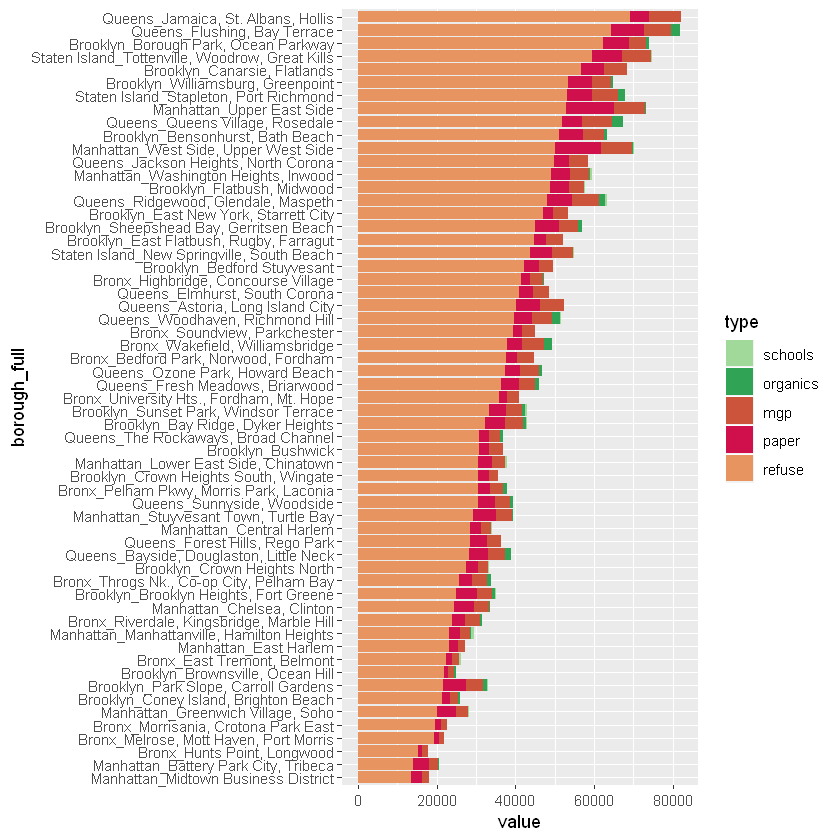

In [26]:
ggplot(data = graph_1, aes(x = borough_full, y = value, 
                           fill = factor(variable, 
                                         levels = c("schools",
                                                    "organics",
                                                    "mgp",
                                                    "paper",
                                                    "refuse"
                                                    )))) + 
geom_col() +
        scale_fill_manual(values = c("#a1d99b", "#31a354", "#CC543A", "#D0104C", "#E79460")) +
        labs(fill = "type") +
        coord_flip()

In [27]:
# ordered by refuse
graph_2 <- j_pop_1 %>% 
arrange(refuse_person) %>%
mutate(borough_full = factor(borough_full, levels = borough_full[order(refuse_person)])) %>% 
gather(variable, value, -borough_full, factor_key = TRUE) %>% 
filter(variable %in% c("refuse_person", "paper_person", "mgp_person", "organics_person", "schools_person"))

In [28]:
head(graph_2)

borough_full,variable,value
<fct>,<fct>,<dbl>
"Manhattan_Lower East Side, Chinatown",refuse_person,375.2764
Manhattan_East Harlem,refuse_person,382.8646
"Manhattan_Stuyvesant Town, Turtle Bay",refuse_person,410.7184
"Brooklyn_Coney Island, Brighton Beach",refuse_person,411.1471
"Brooklyn_Park Slope, Carroll Gardens",refuse_person,414.0580
"Queens_Astoria, Long Island City",refuse_person,419.9168


# Rank community districts by amounts of waste per capita and types of waste

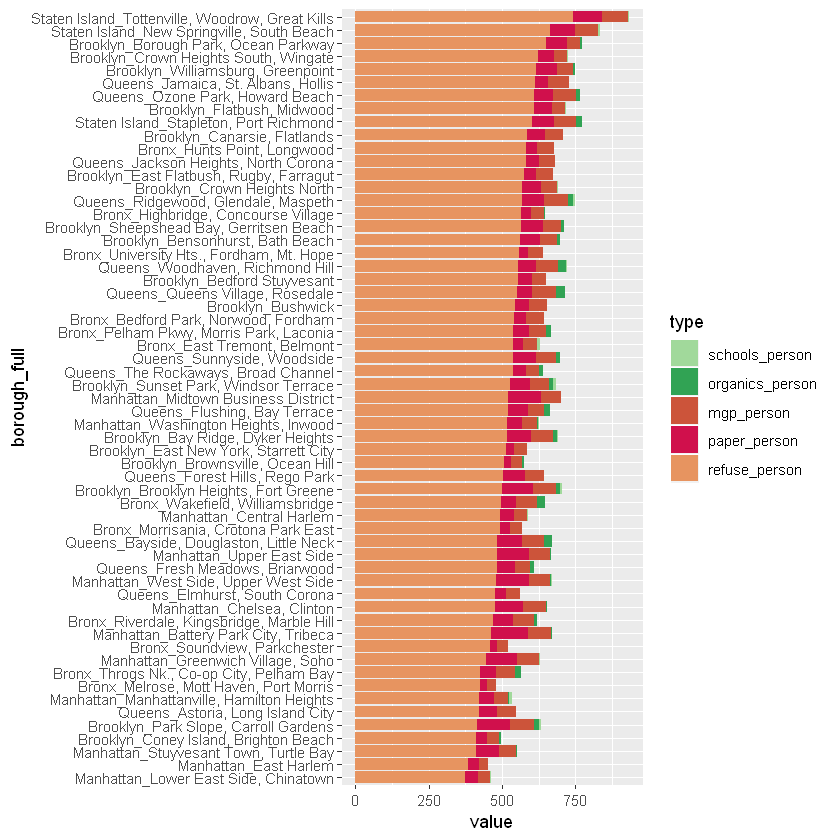

In [29]:
ggplot(data = graph_2, aes(x = borough_full, y = value, 
                           fill = factor(variable, 
                                         levels = c("schools_person",
                                                    "organics_person",
                                                    "mgp_person",
                                                    "paper_person",
                                                    "refuse_person"
                                                    )))) + 
geom_col() +
        scale_fill_manual(values = c("#a1d99b", "#31a354", "#CC543A", "#D0104C", "#E79460")) +
        labs(fill = "type") +
        coord_flip()

In [30]:
share <- graph_2 %>% 
filter(variable == "refuse_person")

head(share)

borough_full,variable,value
<fct>,<fct>,<dbl>
"Manhattan_Lower East Side, Chinatown",refuse_person,375.2764
Manhattan_East Harlem,refuse_person,382.8646
"Manhattan_Stuyvesant Town, Turtle Bay",refuse_person,410.7184
"Brooklyn_Coney Island, Brighton Beach",refuse_person,411.1471
"Brooklyn_Park Slope, Carroll Gardens",refuse_person,414.0580
"Queens_Astoria, Long Island City",refuse_person,419.9168


In [31]:
no_share <- graph_2 %>% 
filter(variable %in% c("paper_person", "mgp_person", "organics_person", "schools_person"))

head(no_share)

borough_full,variable,value
<fct>,<fct>,<dbl>
"Manhattan_Lower East Side, Chinatown",paper_person,42.78374
Manhattan_East Harlem,paper_person,37.49533
"Manhattan_Stuyvesant Town, Turtle Bay",paper_person,79.62030
"Brooklyn_Coney Island, Brighton Beach",paper_person,36.67312
"Brooklyn_Park Slope, Carroll Gardens",paper_person,112.45070
"Queens_Astoria, Long Island City",paper_person,63.65715


In [32]:
share_1 <- share %>% 
mutate(value = value*-1) 

In [33]:
full_table <- bind_rows(share_1, no_share)

In [34]:
head(full_table)

borough_full,variable,value
<fct>,<fct>,<dbl>
"Manhattan_Lower East Side, Chinatown",refuse_person,-375.2764
Manhattan_East Harlem,refuse_person,-382.8646
"Manhattan_Stuyvesant Town, Turtle Bay",refuse_person,-410.7184
"Brooklyn_Coney Island, Brighton Beach",refuse_person,-411.1471
"Brooklyn_Park Slope, Carroll Gardens",refuse_person,-414.0580
"Queens_Astoria, Long Island City",refuse_person,-419.9168


Unsorted waste is the greatest share of all waste produced.

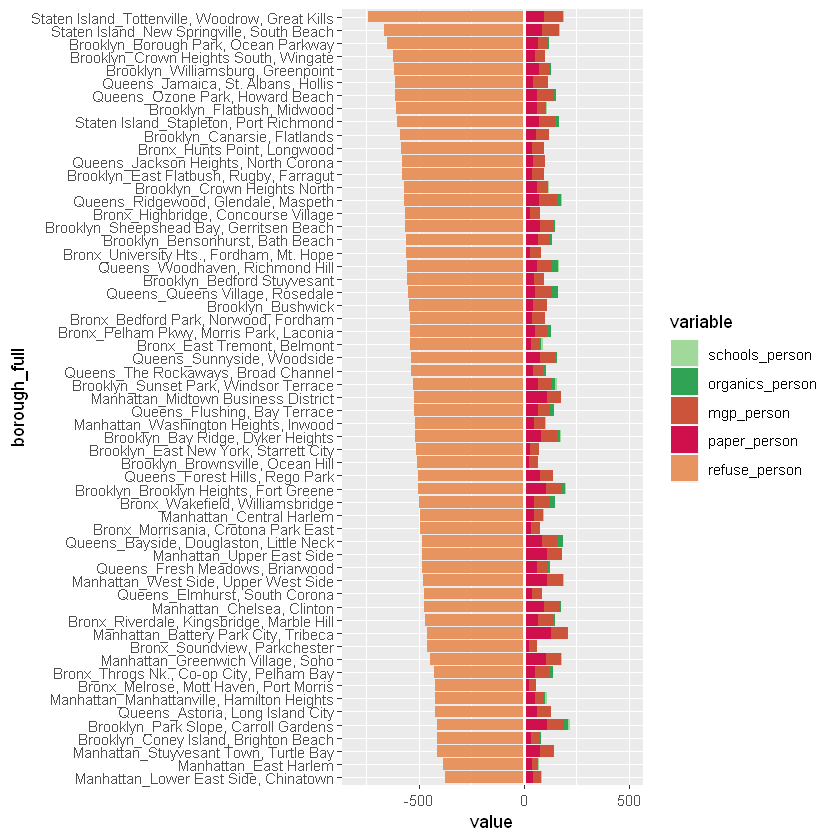

In [35]:
ggplot(data = full_table, aes(x = borough_full, y = value, 
                           fill = factor(variable, 
                                         levels = c("schools_person",
                                                    "organics_person",
                                                    "mgp_person",
                                                    "paper_person",
                                                    "refuse_person"                             
                                                    )))) + 
geom_col() +
        scale_fill_manual(values = c("#a1d99b", "#31a354", "#CC543A", "#D0104C", "#E79460")) +
        labs(fill = "variable") +
coord_flip() +
geom_hline(yintercept=0, color =c("white"), size = 1) +
ylim(-800,500)

# How has the volume per capita of refuse evolved for each community district?

In [36]:
ton_traj <- ton_df %>% 
  separate(col = "month", into = c("year", "month"), sep = "/ ") %>% 
  mutate(year = str_trim(year, side = "both")) %>%
  mutate(borough_id = str_trim(borough_id, side = "both")) %>%
  mutate(communitydistrict = str_trim(communitydistrict, side = "both")) %>% 
  mutate(boroughcd = str_c(borough_id, communitydistrict)) %>% 
  mutate(year_month = make_date(year, month)) %>% 
  mutate(boroughcd = as.numeric(as.character(boroughcd)),
         resorganicstons = as.numeric(as.character(resorganicstons)),
         schoolorganictons = as.numeric(as.character(schoolorganictons))) %>% 

dplyr::mutate(year = as.numeric(as.character(year))) %>% # convert from character to numeric

left_join(pop_1,by = c("boroughcd" = "boroughcd"))%>%
  mutate(refuse_per = refusetonscollected/x2010_population*2000,
         paper_per = papertonscollected/x2010_population*2000,
         refuse_per = refusetonscollected/x2010_population*2000,
         mgp_per = mgptonscollected/x2010_population*2000,
         organics_per = resorganicstons/x2010_population*2000,
         school_per = schoolorganictons/x2010_population*2000) %>% 

group_by(year, borough_full) %>% 
  summarise(refuse = sum(refusetonscollected, na.rm = TRUE), 
            paper = sum(papertonscollected, na.rm = TRUE), 
            mgp = sum(mgptonscollected, na.rm = TRUE),
            organics = sum(resorganicstons, na.rm = TRUE),
            schools = sum(schoolorganictons, na.rm = TRUE),
            
            refuse_person = sum(refuse_per, na.rm = TRUE), 
            paper_person = sum(paper_per, na.rm = TRUE), 
            mgp_person = sum(mgp_per, na.rm = TRUE),
            organics_person = sum(organics_per, na.rm = TRUE),
            schools_person = sum(school_per, na.rm = TRUE))


In [37]:
head(ton_traj)

year,borough_full,refuse,paper,mgp,organics,schools,refuse_person,paper_person,mgp_person,organics_person,schools_person
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1990,"Manhattan_Battery Park City, Tribeca",1815.9,0,0,0,0,59.55919,0,0,0,0
1990,Manhattan_Central Harlem,14429.2,0,0,0,0,249.37480,0,0,0,0
1990,"Manhattan_Chelsea, Clinton",5218.0,0,0,0,0,101.07996,0,0,0,0
1990,Manhattan_East Harlem,14945.3,0,0,0,0,248.03213,0,0,0,0
1990,"Manhattan_Greenwich Village, Soho",7447.3,0,0,0,0,165.46614,0,0,0,0
1990,"Manhattan_Lower East Side, Chinatown",17926.8,0,0,0,0,219.58757,0,0,0,0


In [38]:
ton_traj_1 <- ton_traj %>% 
filter(year > 2005)

head(ton_traj_1)

year,borough_full,refuse,paper,mgp,organics,schools,refuse_person,paper_person,mgp_person,organics_person,schools_person
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2006,"Bronx_Bedford Park, Norwood, Fordham",46792.9,3155.0,3799.8,0,0,671.8967,45.30247,54.56112,0,0
2006,"Bronx_East Tremont, Belmont",28136.6,1108.6,1532.7,0,0,675.8082,26.62728,36.81366,0,0
2006,"Bronx_Highbridge, Concourse Village",54086.9,1924.7,2269.4,0,0,738.6852,26.28635,30.99405,0,0
2006,"Bronx_Hunts Point, Longwood",19757.1,766.1,958.6,0,0,756.3105,29.32665,36.69563,0,0
2006,"Bronx_Melrose, Mott Haven, Port Morris",22578.9,853.8,1004.1,0,0,493.5441,18.66291,21.94826,0,0
2006,"Bronx_Morrisania, Crotona Park East",21636.1,749.6,750.2,0,0,542.5165,18.79592,18.81096,0,0


In [40]:
# view waste in one neighborhood
ton_traj_1 %>% filter(borough_full == "Manhattan_Battery Park City, Tribeca")

year,borough_full,refuse,paper,mgp,organics,schools,refuse_person,paper_person,mgp_person,organics_person,schools_person
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2006,"Manhattan_Battery Park City, Tribeca",13699.6,4342.7,1678.5,0.0,0.0,449.3293,142.4350,55.05264,0.000000,0.000000
2007,"Manhattan_Battery Park City, Tribeca",13602.7,4541.6,1835.1,0.0,0.0,446.1511,148.9586,60.18892,0.000000,0.000000
2008,"Manhattan_Battery Park City, Tribeca",13049.8,4831.4,2017.9,0.0,0.0,428.0167,158.4637,66.18453,0.000000,0.000000
2009,"Manhattan_Battery Park City, Tribeca",13451.8,4809.7,2261.3,0.0,0.0,441.2017,157.7520,74.16773,0.000000,0.000000
2010,"Manhattan_Battery Park City, Tribeca",13993.5,4640.5,2306.4,0.0,0.0,458.9688,152.2024,75.64695,0.000000,0.000000
2011,"Manhattan_Battery Park City, Tribeca",14657.0,4553.2,2351.6,0.0,0.0,480.7308,149.3391,77.12946,0.000000,0.000000
2012,"Manhattan_Battery Park City, Tribeca",15018.9,4031.8,2286.5,0.0,0.0,492.6006,132.2379,74.99426,0.000000,0.000000
2013,"Manhattan_Battery Park City, Tribeca",15349.8,4029.5,2344.1,0.0,110.6,503.4537,132.1624,76.88347,0.000000,3.627538
2014,"Manhattan_Battery Park City, Tribeca",15640.1,4217.3,2412.8,34.0,358.5,512.9752,138.3220,79.13674,1.115156,11.758339


`geom_smooth()` using method = 'loess' and formula 'y ~ x'


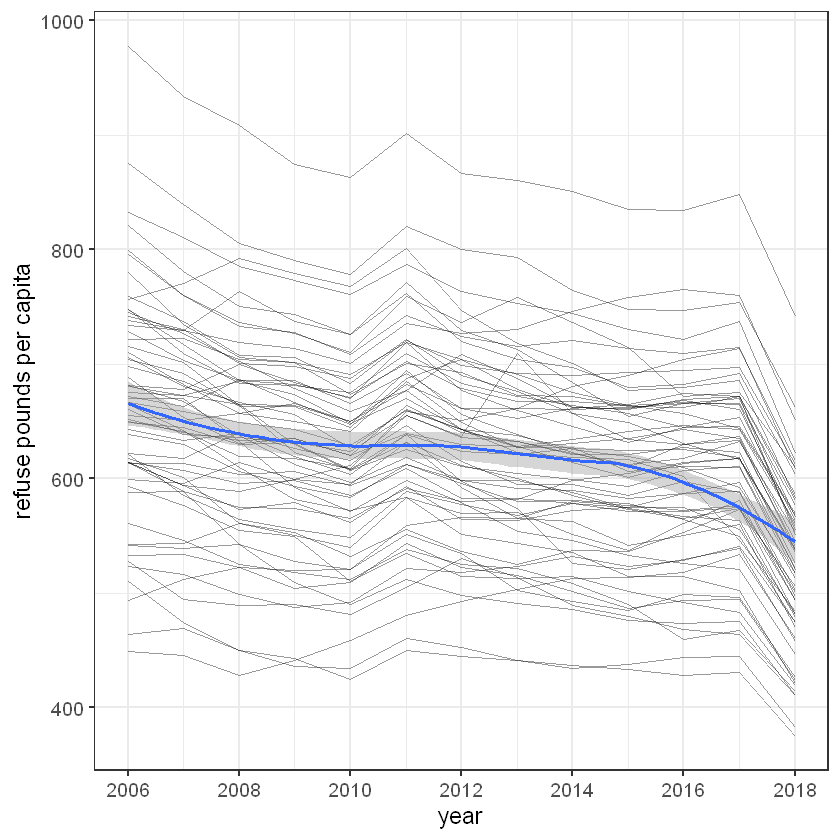

In [85]:
# Visualize trajectories
ggplot(ton_traj_1, aes(x = year, y = refuse_person)) +
  geom_line(aes(group = borough_full), alpha = 0.4) +
  geom_smooth() +
  xlab('year') +
  ylab('refuse pounds per capita') + 
  theme_bw(base_size = 14) +
scale_x_continuous(breaks = scales::pretty_breaks(n = 8))

Refuse per capita has declined in all borroughs.

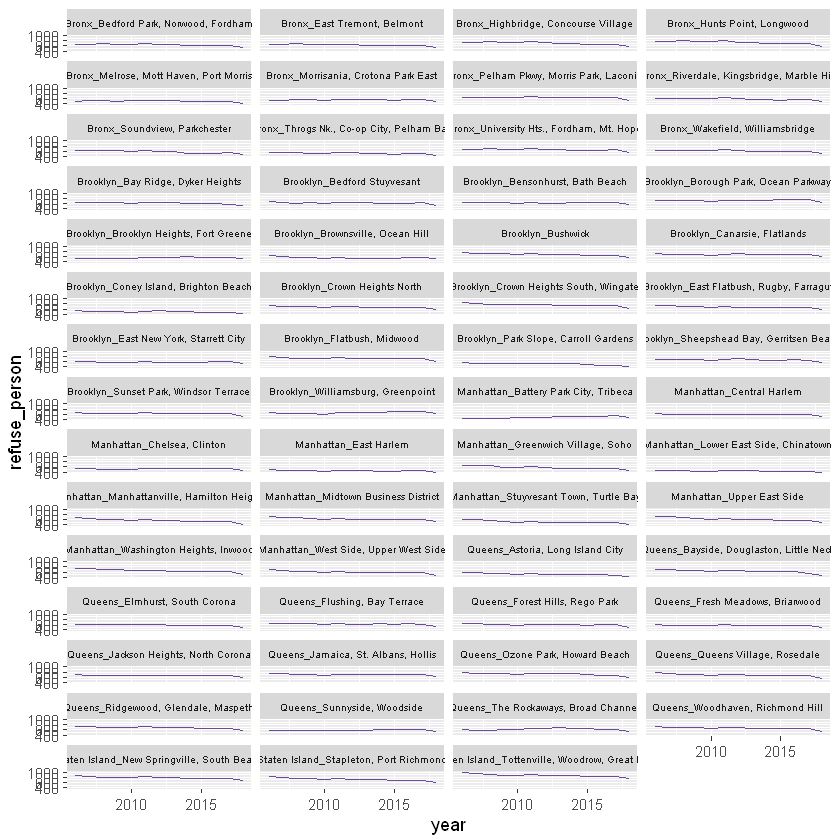

In [60]:
p <- ggplot(data = ton_traj_1,
            mapping = aes(x = year,
                           y = refuse_person))
p + geom_line(color="#6A4C9C", aes(group = borough_full)) + 
facet_wrap(~ borough_full, ncol = 4) +
theme(strip.text.x = element_text(size = 6, lineheight=6.0)) 

## What are the trends of other types of refuse?

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


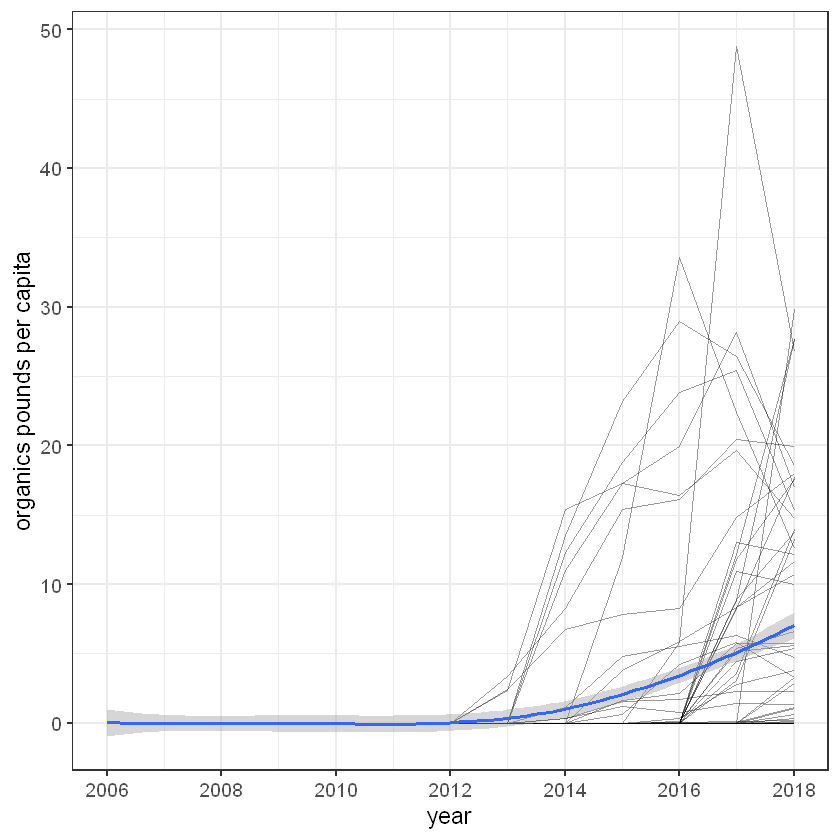

In [86]:
# Visualize trajectories of other types of waste
ggplot(ton_traj_1, aes(x = year, y = organics_person)) +
  geom_line(aes(group = borough_full), alpha = 0.4) +
  geom_smooth() +
  xlab('year') +
  ylab('organics pounds per capita') +
  theme_bw(base_size = 14) +
scale_x_continuous(breaks = scales::pretty_breaks(n = 8))

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


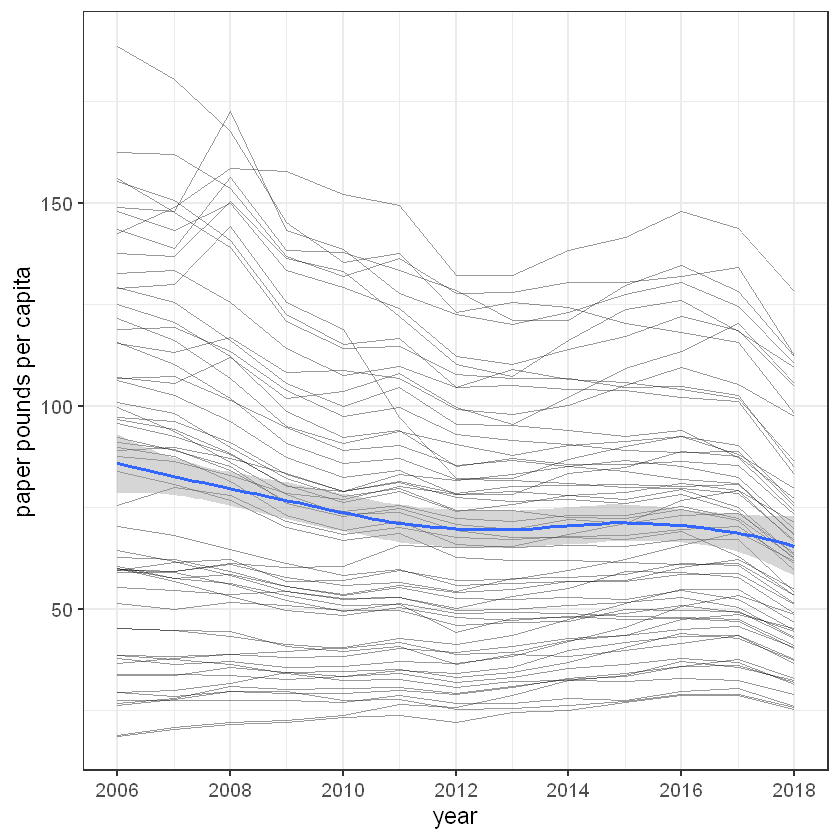

In [87]:
ggplot(ton_traj_1, aes(x = year, y = paper_person)) +
  geom_line(aes(group = borough_full), alpha = 0.4) +
  geom_smooth() +
  xlab('year') +
  ylab('paper pounds per capita') +
  theme_bw(base_size = 14) +
scale_x_continuous(breaks = scales::pretty_breaks(n = 8))

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


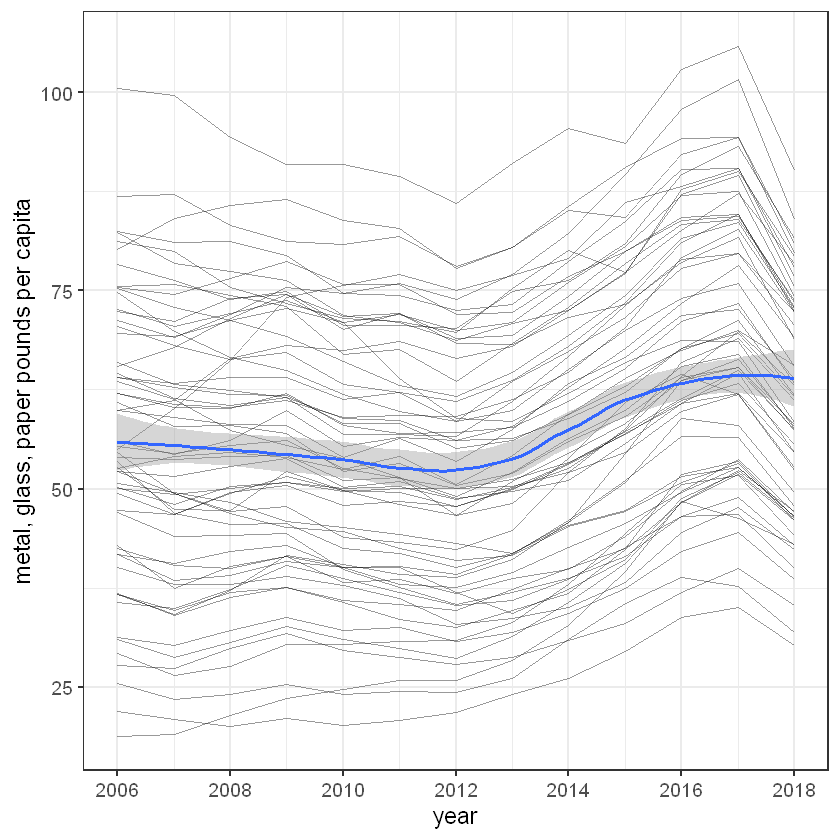

In [88]:
ggplot(ton_traj_1, aes(x = year, y = mgp_person)) +
  geom_line(aes(group = borough_full), alpha = 0.4) +
  geom_smooth() +
  xlab('year') +
  ylab('metal, glass, paper pounds per capita') +
  theme_bw(base_size = 14) +
scale_x_continuous(breaks = scales::pretty_breaks(n = 8))

## Is it possible to detect a distinct trend of waste generation?

In [89]:
ton_traj_2 <- ton_df %>% 
  separate(col = "month", into = c("year", "month"), sep = "/ ") %>% 
  mutate(year = str_trim(year, side = "both")) %>%
  mutate(borough_id = str_trim(borough_id, side = "both")) %>%
  mutate(communitydistrict = str_trim(communitydistrict, side = "both")) %>% 
  mutate(boroughcd = str_c(borough_id, communitydistrict)) %>% 
  mutate(year_month = make_date(year, month)) %>% 
  mutate(boroughcd = as.numeric(as.character(boroughcd)),
         resorganicstons = as.numeric(as.character(resorganicstons)),
         schoolorganictons = as.numeric(as.character(schoolorganictons))) %>% 

dplyr::mutate(year = as.numeric(as.character(year))) %>% # convert from character to numeric

left_join(pop_1,by = c("boroughcd" = "boroughcd"))%>%
  mutate(refuse_per = refusetonscollected/x2010_population*2000,
         paper_per = papertonscollected/x2010_population*2000,
         refuse_per = refusetonscollected/x2010_population*2000,
         mgp_per = mgptonscollected/x2010_population*2000,
         organics_per = resorganicstons/x2010_population*2000,
         school_per = schoolorganictons/x2010_population*2000) %>% 

group_by(year, borough.x, borough_full) %>% 
  summarise(refuse = sum(refusetonscollected, na.rm = TRUE), 
            paper = sum(papertonscollected, na.rm = TRUE), 
            mgp = sum(mgptonscollected, na.rm = TRUE),
            organics = sum(resorganicstons, na.rm = TRUE),
            schools = sum(schoolorganictons, na.rm = TRUE),
            
            refuse_person = sum(refuse_per, na.rm = TRUE), 
            paper_person = sum(paper_per, na.rm = TRUE), 
            mgp_person = sum(mgp_per, na.rm = TRUE),
            organics_person = sum(organics_per, na.rm = TRUE),
            schools_person = sum(school_per, na.rm = TRUE)) %>% 
filter(year >= 1995)

head(ton_traj_2)


year,borough.x,borough_full,refuse,paper,mgp,organics,schools,refuse_person,paper_person,mgp_person,organics_person,schools_person
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1995,Bronx,"Bronx_Bedford Park, Norwood, Fordham",46404.3,2234.5,2255.4,0,0,666.3168,32.085062,32.38516,0,0
1995,Bronx,"Bronx_East Tremont, Belmont",24611.3,533.2,748.0,0,0,591.1346,12.806841,17.96609,0,0
1995,Bronx,"Bronx_Highbridge, Concourse Village",49047.8,1318.4,1367.1,0,0,669.8643,18.005886,18.67100,0,0
1995,Bronx,"Bronx_Hunts Point, Longwood",18415.6,373.9,588.2,0,0,704.9573,14.313057,22.51656,0,0
1995,Bronx,"Bronx_Melrose, Mott Haven, Port Morris",26316.2,452.3,566.3,0,0,575.2363,9.886663,12.37855,0,0
1995,Bronx,"Bronx_Morrisania, Crotona Park East",23453.3,420.5,554.1,0,0,588.0820,10.543868,13.89383,0,0


`geom_smooth()` using method = 'loess' and formula 'y ~ x'


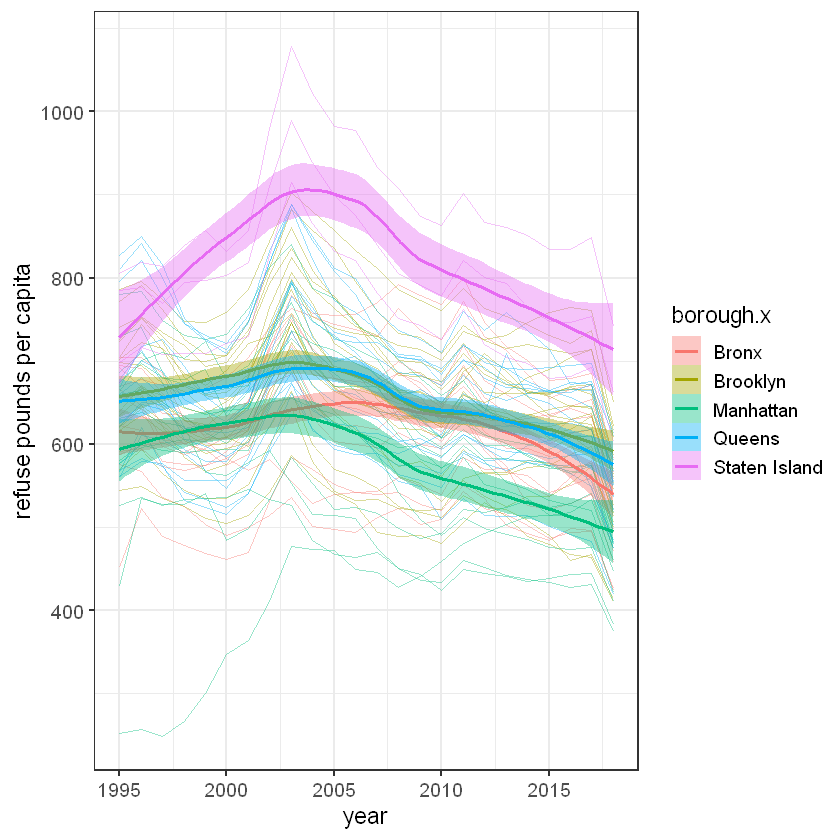

In [94]:
# Visualize trajectories
ggplot(ton_traj_2, aes(x = year, y = refuse_person, color = borough.x, fill = borough.x)) +
  geom_line(aes(group = borough_full), alpha = 0.4) +
  geom_smooth() +
  xlab('year') +
  ylab('refuse pounds per capita') +
  theme_bw(base_size = 14) 

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


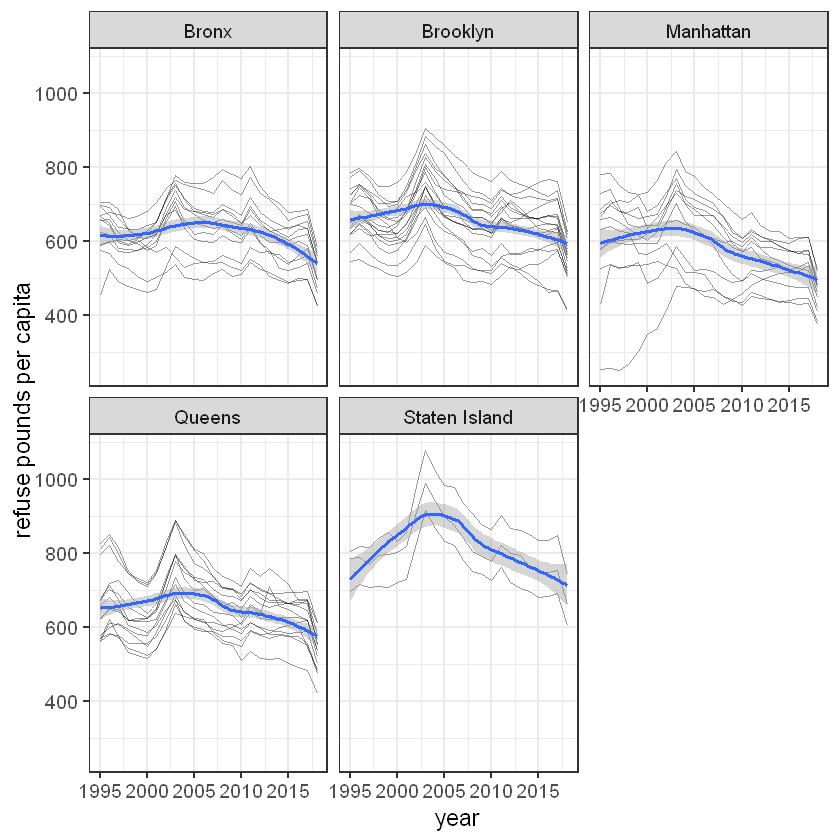

In [355]:
p <- ggplot(data = ton_traj_2,
            mapping = aes(x = year,
                          y = refuse_person))

p + geom_line(aes(group = borough_full), alpha = 0.4) +
  geom_smooth() +
  xlab('year') +
  ylab('refuse pounds per capita') +
  theme_bw(base_size = 14) + facet_wrap(~ borough.x)

It appears that Staten Island boroughs overall have higher trends of refuse generation. The community districs of the other four boroughs have a wider range and overlap.

It would be interesting to do a clustering analysis to group all community disctricts by thier waste generation rates and see if there are any other common cacracteristics (socio-demographic caracteristics, infrustructure, etc.)

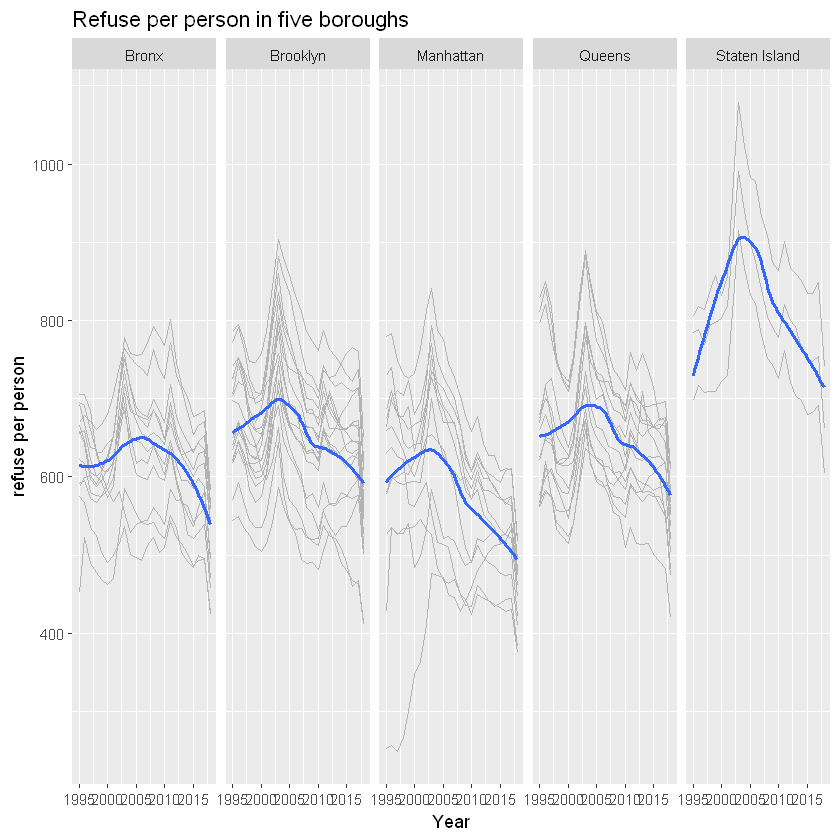

In [358]:
p <- ggplot(data = ton_traj_2, mapping = aes(x = year, y = refuse_person))
p + geom_line(color="gray70", aes(group = borough_full)) +
    geom_smooth(size = 1.1, method = "loess", se = FALSE) +

    facet_wrap(~ borough.x, ncol = 5) +
    labs(x = "Year",
         y = "refuse per person",
         title = "Refuse per person in five boroughs")

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


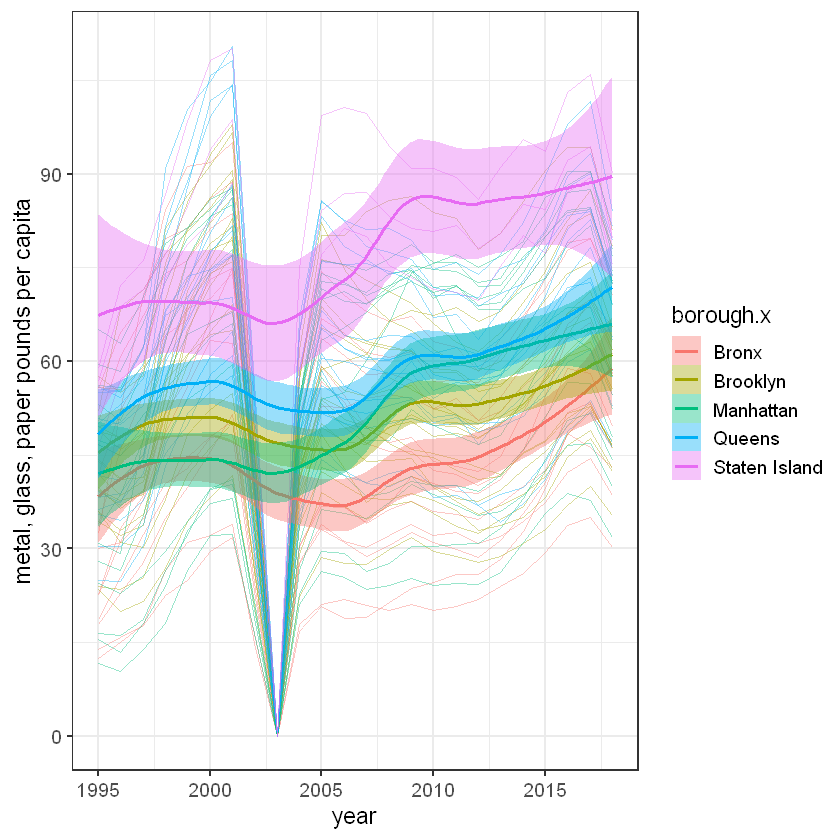

In [97]:
ggplot(ton_traj_2, aes(x = year, y = mgp_person, color = borough.x, fill = borough.x)) +
  geom_line(aes(group = borough_full), alpha = 0.4) +
  geom_smooth() +
  xlab('year') +
  ylab('metal, glass, paper pounds per capita') +
  theme_bw(base_size = 14) 